<a href="https://colab.research.google.com/github/nan-hk/-motion-artifacts/blob/master/keras_UNet_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, UpSampling2D, concatenate
from tensorflow.keras.optimizers import Adam


def unet(pretrained_weights = None,input_size = (256,256,1)):
    inputs = Input(input_size)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4) # for crop and copy
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)
    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis =3) # Concatenate for localization informantion
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)
    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)
    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 1)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)
    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 1)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(1, 1, activation = 'softmax')(conv9)
    model = Model(inputs=inputs, outputs=conv10)
    model.compile(optimizer = 'sgd', loss = 'mse', metrics = ['accuracy'])

    #model.summary()

    if(pretrained_weights):
        model.load_weights(pretrained_weights)

    return model

In [ ]:
import numpy as np
from scipy.ndimage.interpolation import map_coordinates
from scipy.ndimage.filters import gaussian_filter
from random import randint


def add_elastic_transform(image, alpha, sigma, pad_size=30, seed=None):
    """
    Args:
        image : numpy array of image
        alpha : α is a scaling factor
        sigma :  σ is an elasticity coefficient
        random_state = random integer
        Return :
        image : elastically transformed numpy array of image
    """
    image_size = int(image.shape[0])
    image = np.pad(image, pad_size, mode="symmetric")
    if seed is None:
        seed = randint(1, 100)
        random_state = np.random.RandomState(seed)
    else:
        random_state = np.random.RandomState(seed)
    shape = image.shape
    dx = gaussian_filter((random_state.rand(*shape) * 2 - 1),
                         sigma, mode="constant", cval=0) * alpha
    dy = gaussian_filter((random_state.rand(*shape) * 2 - 1),
                         sigma, mode="constant", cval=0) * alpha
    x, y = np.meshgrid(np.arange(shape[1]), np.arange(shape[0]))
    indices = np.reshape(y+dy, (-1, 1)), np.reshape(x+dx, (-1, 1))
    return cropping(map_coordinates(image, indices, order=1).reshape(shape), 512, pad_size, pad_size), seed


def flip(image, option_value):
    """
    Args:
        image : numpy array of image
        option_value = random integer between 0 to 3
    Return :
        image : numpy array of flipped image
    """
    if option_value == 0:
        # vertical
        image = np.flip(image, option_value)
    elif option_value == 1:
        # horizontal
        image = np.flip(image, option_value)
    elif option_value == 2:
        # horizontally and vertically flip
        image = np.flip(image, 0)
        image = np.flip(image, 1)
    else:
        image = image
        # no effect
    return image


def add_gaussian_noise(image, mean=0, std=1):
    """
    Args:
        image : numpy array of image
        mean : pixel mean of image
        standard deviation : pixel standard deviation of image
    Return :
        image : numpy array of image with gaussian noise added
    """
    gaus_noise = np.random.normal(mean, std, image.shape)
    image = image.astype("int16")
    noise_img = image + gaus_noise
    image = ceil_floor_image(image)
    return noise_img


def add_uniform_noise(image, low=-10, high=10):
    """
    Args:
        image : numpy array of image
        low : lower boundary of output interval
        high : upper boundary of output interval
    Return :
        image : numpy array of image with uniform noise added
    """
    uni_noise = np.random.uniform(low, high, image.shape)
    image = image.astype("int16")
    noise_img = image + uni_noise
    image = ceil_floor_image(image)
    return noise_img


def change_brightness(image, value):
    """
    Args:
        image : numpy array of image
        value : brightness
    Return :
        image : numpy array of image with brightness added
    """
    image = image.astype("int16")
    image = image + value
    image = ceil_floor_image(image)
    return image


def ceil_floor_image(image):
    """
    Args:
        image : numpy array of image in datatype int16
    Return :
        image : numpy array of image in datatype uint8 with ceilling(maximum 255) and flooring(minimum 0)
    """
    image[image > 255] = 255
    image[image < 0] = 0
    image = image.astype("uint8")
    return image


def approximate_image(image):
    """
    Args:
        image : numpy array of image in datatype int16
    Return :
        image : numpy array of image in datatype uint8 only with 255 and 0
    """
    image[image > 127.5] = 255
    image[image < 127.5] = 0
    image = image.astype("uint8")
    return image


def normalization1(image, mean, std):
    """ Normalization using mean and std
    Args :
        image : numpy array of image
        mean :
    Return :
        image : numpy array of image with values turned into standard scores
    """

    image = image / 255  # values will lie between 0 and 1.
    image = (image - mean) / std

    return image


def normalization2(image, max, min):
    """Normalization to range of [min, max]
    Args :
        image : numpy array of image
        mean :
    Return :
        image : numpy array of image with values turned into standard scores
    """
    image_new = (image - np.min(image))*(max - min)/(np.max(image)-np.min(image)) + min
    return image_new


def stride_size(image_len, crop_num, crop_size):
    """return stride size
    Args :
        image_len(int) : length of one size of image (width or height)
        crop_num(int) : number of crop in certain direction
        crop_size(int) : size of crop
    Return :
        stride_size(int) : stride size
    """
    return int((image_len - crop_size)/(crop_num - 1))


def multi_cropping(image, crop_size, crop_num1, crop_num2):
    """crop the image and pad it to in_size
    Args :
        images : numpy arrays of images
        crop_size(int) : size of cropped image
        crop_num2 (int) : number of crop in horizontal way
        crop_num1 (int) : number of crop in vertical way
    Return :
        cropped_imgs : numpy arrays of stacked images
    """

    img_height, img_width = image.shape[0], image.shape[1]
    assert crop_size*crop_num1 >= img_width and crop_size * \
        crop_num2 >= img_height, "Whole image cannot be sufficiently expressed"
    assert crop_num1 <= img_width - crop_size + 1 and crop_num2 <= img_height - \
        crop_size + 1, "Too many number of crops"

    cropped_imgs = []
    # int((img_height - crop_size)/(crop_num1 - 1))
    dim1_stride = stride_size(img_height, crop_num1, crop_size)
    # int((img_width - crop_size)/(crop_num2 - 1))
    dim2_stride = stride_size(img_width, crop_num2, crop_size)
    for i in range(crop_num1):
        for j in range(crop_num2):
            cropped_imgs.append(cropping(image, crop_size,
                                         dim1_stride*i, dim2_stride*j))
    return np.asarray(cropped_imgs)


# IT IS NOT USED FOR PAD AND CROP DATA OPERATION
# IF YOU WANT TO USE CROP AND PAD USE THIS FUNCTION
"""
def multi_padding(images, in_size, out_size, mode):
    '''Pad the images to in_size
    Args :
        images : numpy array of images (CxHxW)
        in_size(int) : the input_size of model (512)
        out_size(int) : the output_size of model (388)
        mode(str) : mode of padding
    Return :
        padded_imgs: numpy arrays of padded images
    '''
    pad_size = int((in_size - out_size)/2)
    padded_imgs = []
    for num in range(images.shape[0]):
        padded_imgs.append(add_padding(images[num], in_size, out_size, mode=mode))
    return np.asarray(padded_imgs)
"""


def cropping(image, crop_size, dim1, dim2):
    """crop the image and pad it to in_size
    Args :
        images : numpy array of images
        crop_size(int) : size of cropped image
        dim1(int) : vertical location of crop
        dim2(int) : horizontal location of crop
    Return :
        cropped_img: numpy array of cropped image
    """
    cropped_img = image[dim1:dim1+crop_size, dim2:dim2+crop_size]
    return cropped_img


def add_padding(image, in_size, out_size, mode):
    """Pad the image to in_size
    Args :
        images : numpy array of images
        in_size(int) : the input_size of model
        out_size(int) : the output_size of model
        mode(str) : mode of padding
    Return :
        padded_img: numpy array of padded image
    """
    pad_size = int((in_size - out_size)/2)
    padded_img = np.pad(image, pad_size, mode=mode)
    return padded_img


def division_array(crop_size, crop_num1, crop_num2, dim1, dim2):
    """Make division array
    Args :
        crop_size(int) : size of cropped image
        crop_num2 (int) : number of crop in horizontal way
        crop_num1 (int) : number of crop in vertical way
        dim1(int) : vertical size of output
        dim2(int) : horizontal size_of_output
    Return :
        div_array : numpy array of numbers of 1,2,4
    """
    div_array = np.zeros([dim1, dim2])  # make division array
    one_array = np.ones([crop_size, crop_size])  # one array to be added to div_array
    dim1_stride = stride_size(dim1, crop_num1, crop_size)  # vertical stride
    dim2_stride = stride_size(dim2, crop_num2, crop_size)  # horizontal stride
    for i in range(crop_num1):
        for j in range(crop_num2):
            # add ones to div_array at specific position
            div_array[dim1_stride*i:dim1_stride*i + crop_size,
                      dim2_stride*j:dim2_stride*j + crop_size] += one_array
    return div_array


def image_concatenate(image, crop_num1, crop_num2, dim1, dim2):
    """concatenate images
    Args :
        image : output images (should be square)
        crop_num2 (int) : number of crop in horizontal way (2)
        crop_num1 (int) : number of crop in vertical way (2)
        dim1(int) : vertical size of output (512)
        dim2(int) : horizontal size_of_output (512)
    Return :
        div_array : numpy arrays of numbers of 1,2,4
    """
    crop_size = image.shape[1]  # size of crop
    empty_array = np.zeros([dim1, dim2]).astype("float64")  # to make sure no overflow
    dim1_stride = stride_size(dim1, crop_num1, crop_size)  # vertical stride
    dim2_stride = stride_size(dim2, crop_num2, crop_size)  # horizontal stride
    index = 0
    for i in range(crop_num1):
        for j in range(crop_num2):
            # add image to empty_array at specific position
            empty_array[dim1_stride*i:dim1_stride*i + crop_size,
                        dim2_stride*j:dim2_stride*j + crop_size] += image[index]
            index += 1
    return empty_array

# **Start Running From Here**


In [1]:
import zipfile
from google.colab import drive

drive.mount('/content/drive/')

zip_ref = zipfile.ZipFile("/content/drive/My Drive/data.zip", 'r')
zip_ref.extractall("/content/tmp")
zip_ref.close()

Mounted at /content/drive/


In [2]:
from keras.preprocessing.image import img_to_array, load_img
import numpy as np
import glob
from PIL import Image, ImageSequence
import os

class dataProcess(object):
    def __init__(self, out_rows, out_cols, data_path="/content/tmp/data"):
        self.out_rows = out_rows
        self.out_cols = out_cols
        self.data_path = data_path

    def create_train_data(self):
        print('-' * 30)
        print('Creating train images...')
        print('-' * 30)

        # Load images and convert to npy
        i = 0
        j = 0
        imgs = os.listdir(self.data_path + "/raw/images/")
        aug_imgs = os.listdir(self.data_path + "/aug/images/")
        print("original images", len(imgs))
        print("augmented images", len(aug_imgs))
        img_datas = np.ndarray((len(imgs) + len(aug_imgs), self.out_rows, self.out_cols, 1), dtype=np.uint8)
        img_labels = np.ndarray((len(imgs) + len(aug_imgs), self.out_rows, self.out_cols, 1), dtype=np.uint8)
        for imgname in imgs:
            img = load_img(self.data_path + "/raw/images/" + imgname, color_mode="grayscale", target_size=(256,256))
            label = load_img(self.data_path + "/raw/labels/corrupted_" + imgname, color_mode="grayscale", target_size=(256,256))
            img_datas[j] = img_to_array(img)
            img_labels[j] = img_to_array(label)
            j += 1
            if j % len(imgs) == 0:
                print('Done: {0}/{1} images'.format(j, len(imgs)))
        for imgname in aug_imgs:
            img = load_img(self.data_path + "/aug/images/" + imgname, color_mode="grayscale", target_size=(256,256))
            label = load_img(self.data_path + "/aug/labels/corrupted_" + imgname, color_mode="grayscale", target_size=(256,256))
            img_datas[i + len(imgs)] = img_to_array(img)
            img_labels[i + len(imgs)] = img_to_array(label)
            i += 1
            if i % 100 == 0:
                print('Done: {0}/{1} images'.format(i, len(aug_imgs)))

        print('loading done')
        np.save(self.data_path + '/npy/imgs_train.npy', img_datas)
        np.save(self.data_path + '/npy/imgs_mask_train.npy', img_labels)
        print('Saving to .npy files done.')

    def create_test_data(self):
        print('-' * 30)
        print('Creating test images...')
        print('-' * 30)

        # Create directory
        if not os.path.exists(self.data_path + "/test/images"):
            os.makedirs(self.data_path + "/test/images")
        if not os.path.exists(self.data_path + "/test/labels"):
            os.makedirs(self.data_path + "/test/labels")

        # Split isbi tif image&label to single frame of png images
  #      isbi_img = Image.open(self.data_path + "/test-volume.tif")  # raw image from isbi dataset
   #     for i, page in enumerate(ImageSequence.Iterator(isbi_img)):
   #         page.save(self.data_path+"/test/images/" + str(i) + ".png")

        imgs = os.listdir(self.data_path + "/test/images/")
        imgs = sorted([str(i).rstrip('.png').lstrip('GT_') for i in imgs], key=int) # sort accending
        img_datas = np.ndarray((len(imgs), self.out_rows, self.out_cols, 1), dtype=np.uint8)
        i = 0
        for imgname in imgs:
            img = load_img(self.data_path + "/test/images/GT_" + imgname + ".png", color_mode="grayscale", target_size=(256,256))
            img_datas[i] = img_to_array(img)
            i += 1
            if i % len(imgs) == 0:
                print('Done: {0}/{1} images'.format(i, len(imgs)))
        print('loading done')
        np.save(self.data_path + '/npy/imgs_test.npy', img_datas)
        print('Saving to .npy files done.')

    def load_train_data(self):
        print('-' * 30)
        print('load train images...')
        print('-' * 30)
        imgs_train = np.load(self.data_path + "/npy/imgs_train.npy")
        imgs_mask_train = np.load(self.data_path + "/npy/imgs_mask_train.npy")
        imgs_train = imgs_train.astype('float32')
        imgs_mask_train = imgs_mask_train.astype('float32')
        imgs_train /= 255  # RGB 0~1
        imgs_mask_train /= 255
        imgs_mask_train[imgs_mask_train > 0.5] = 1
        imgs_mask_train[imgs_mask_train <= 0.5] = 0
        return imgs_train, imgs_mask_train

    def load_test_data(self):
        print('-' * 30)
        print('load test images...')
        print('-' * 30)
        imgs_test = np.load(self.data_path + "/npy/imgs_test.npy")
        imgs_test = imgs_test.astype('float32')
        imgs_test /= 255
        return imgs_test


if __name__ == "__main__":
    mydata = dataProcess(256, 256)
    mydata.create_train_data()
    mydata.create_test_data()

------------------------------
Creating train images...
------------------------------
original images 3001
augmented images 950
Done: 3001/3001 images
Done: 100/950 images
Done: 200/950 images
Done: 300/950 images
Done: 400/950 images
Done: 500/950 images
Done: 600/950 images
Done: 700/950 images
Done: 800/950 images
Done: 900/950 images
loading done
Saving to .npy files done.
------------------------------
Creating test images...
------------------------------
Done: 50/50 images
loading done
Saving to .npy files done.


In [3]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.models import Model
import numpy as np
import tensorflow as tf
from tensorflow.keras.optimizers import Adam

def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def unet(input_shape):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024)

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    model = Model(inputs, outputs, name="U-Net")
    return model

# New section

In [4]:
from keras.preprocessing import *
#from model import unet
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tifffile import imsave as tifsave
import tensorflow as tf

# Use other GPU in our mlti-gpu server
# If you have only one GPU, change 1 to 0 or delete below lines
gpus = tf.config.experimental.list_physical_devices('GPU')

class myUnet(object):

    def __init__(self, img_rows=256, img_cols=256, save_path="/content/tmp/data/results/"):
        self.img_rows = img_rows
        self.img_cols = img_cols
        self.save_path = save_path

    def load_data(self):
        mydata = dataProcess(self.img_rows, self.img_cols)
        imgs_train, imgs_mask_train = mydata.load_train_data()
        imgs_test = mydata.load_test_data()
        return imgs_train, imgs_mask_train, imgs_test

    def train(self, load_pretrained):
        print("loading data")
        model_name = '/content/tmp/data/results/my_model.h5'
        log_dir = "/content/tmp/data/logs/000"
        logging = TensorBoard(log_dir=log_dir)
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)
        early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1)
        imgs_train, imgs_mask_train, imgs_test = self.load_data()
        print (imgs_train, imgs_mask_train.size)
        print("loading data done")
        if load_pretrained:
            model = load_model(model_name)
            model.compile(optimizer='sgd', loss='mean_squared_error', metrics=['accuracy'])
            model_checkpoint = ModelCheckpoint('unet.h5', monitor='val_loss', verbose=1, save_best_only=True)
            model.fit(imgs_train, imgs_mask_train, batch_size=4, epochs=30, verbose=1,
                      validation_split=0.2, shuffle=True, callbacks=[logging, model_checkpoint, reduce_lr])
            model.save(model_name)
        else:
            model = unet((256,256,1))
            model.compile(optimizer = 'sgd', loss = 'mse', metrics = ['accuracy'])
            #model = unet()
            model.summary()
            model_checkpoint = ModelCheckpoint('unet.h5', monitor='val_loss', verbose=1, save_best_only=True)
            model.fit(imgs_train, imgs_mask_train, batch_size=4, epochs=10, verbose=1,
                      validation_split=0.2, shuffle=True,
                      callbacks=[logging, model_checkpoint, reduce_lr, early_stopping])
            model.save(model_name)

    def test(self):
        model_name = '/content/tmp/data/results/my_model.h5'
        if not os.path.exists(self.save_path):
            os.makedirs(self.save_path)

        imgs_train, imgs_mask_train, imgs_test = self.load_data()
        model = load_model(model_name)
        imgs_mask_test = model.predict(imgs_test, batch_size=2, verbose=1)
        np.save(self.save_path + "imgs_mask_test.npy", imgs_mask_test)

        print("array to image")
        imgs = np.load(self.save_path + "imgs_mask_test.npy")
        total = []
        for i in range(imgs.shape[0]):
            img = imgs[i]
            img[img > 0.5] = 1
            img[img <= 0.5] = 0
            total.append(img)
        np_total = np.array(total)
        tifsave("/content/tmp/data/results/prediction.tif", np_total)


if __name__ == '__main__':
      try:
          myunet = myUnet()
          myunet.train(load_pretrained=False)
          myunet.test()
      except RuntimeError as e:
          print(e)

loading data
------------------------------
load train images...
------------------------------
------------------------------
load test images...
------------------------------
[[[[0.        ]
   [0.        ]
   [0.        ]
   ...
   [0.        ]
   [0.        ]
   [0.        ]]

  [[0.        ]
   [0.        ]
   [0.        ]
   ...
   [0.        ]
   [0.        ]
   [0.        ]]

  [[0.        ]
   [0.        ]
   [0.        ]
   ...
   [0.        ]
   [0.        ]
   [0.        ]]

  ...

  [[0.        ]
   [0.        ]
   [0.00392157]
   ...
   [0.00392157]
   [0.        ]
   [0.        ]]

  [[0.        ]
   [0.        ]
   [0.        ]
   ...
   [0.        ]
   [0.        ]
   [0.        ]]

  [[0.        ]
   [0.        ]
   [0.        ]
   ...
   [0.        ]
   [0.        ]
   [0.        ]]]


 [[[0.        ]
   [0.        ]
   [0.        ]
   ...
   [0.        ]
   [0.        ]
   [0.        ]]

  [[0.        ]
   [0.        ]
   [0.        ]
   ...
   [0.        ]
   [0. 

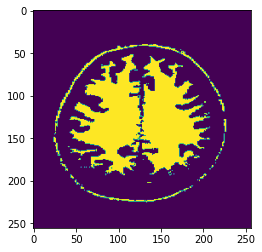

In [17]:
import matplotlib.pyplot as plt
img = plt.imread('/content/tmp/data/results/prediction.tif')
plt.imshow(img[:, :, 0])
plt.show()